In [1]:
import spacy
import string
import pickle as pkl
import pandas as pd
from collections import Counter
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv

In [3]:
# import data 
data_dir = './data/'

# Read in dataset (pre-tokenized)
train_df = pd.read_csv(data_dir+"snli_train.tsv",sep='\t')
val_df = pd.read_csv(data_dir+"snli_val.tsv",sep='\t')

# Process the label to usable format: (neutral:0, entailment:1, contradiction:2)
mapping = {'neutral': 0, 'entailment': 1, 'contradiction': 2}
train_df = train_df.applymap(lambda s: mapping.get(s) if s in mapping else s)
val_df = val_df.applymap(lambda s: mapping.get(s) if s in mapping else s)

# Then, load preprocessed train, val and test datasets
train_data_tokens_1 = pkl.load(open(data_dir+"train_data_tokens_1.p", "rb"))
train_data_tokens_2 = pkl.load(open(data_dir+"train_data_tokens_2.p", "rb"))
all_train_tokens = pkl.load(open(data_dir+"all_train_concat_tokens.p", "rb"))
val_data_tokens_1 = pkl.load(open(data_dir+"val_data_tokens_1.p", "rb"))
val_data_tokens_2 = pkl.load(open(data_dir+"val_data_tokens_2.p", "rb"))

# getting the target values for training and validation
train_target = train_df['label'].tolist()
val_target = val_df['label'].tolist()

# double checking
print ("Train dataset size (sentence 1) is {}".format(len(train_data_tokens_1)))
print ("Train dataset size (sentence 2) is {}".format(len(train_data_tokens_2)))
print ("Val dataset size (sentence 1) is {}".format(len(val_data_tokens_1)))
print ("Val dataset size (sentence 2) is {}".format(len(val_data_tokens_2)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))
print ("Total number of *unique* tokens in train dataset is {}".format(len(set(all_train_tokens))))
        

Train dataset size (sentence 1) is 100000
Train dataset size (sentence 2) is 100000
Val dataset size (sentence 1) is 1000
Val dataset size (sentence 2) is 1000
Total number of tokens in train dataset is 2038281
Total number of *unique* tokens in train dataset is 19643


In [4]:
import io
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    cnt = 0
    for line in fin:
        if cnt == 50000:
            break
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
        cnt += 1
    return data

In [5]:
embedding_mtx = load_vectors("./wiki-news-300d-1M.vec")

In [6]:
PAD_IDX = 0
UNK_IDX = 1

def build_vocab_frozen(frozen_dict):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    id2token = list(frozen_dict.keys())
    token2id = dict(zip(frozen_dict.keys(), range(2,50002))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab_frozen(embedding_mtx)

# convert token to id in the dataset
def token2index_dataset(token2id, tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [7]:
weight_np = []
weight_np.append([0]*300)
weight_np.append([0]*300)
for index in range(2, 2 + len(embedding_mtx.values())):
    weight_np.append(list(embedding_mtx[id2token[index]]))
    
weight_np = torch.FloatTensor(weight_np)

In [8]:
def bow_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list_1 = []
    length_list_2 = []
    
    for datum in batch:
        label_list.append(datum[4])
        length_list_1.append(datum[2])
        length_list_2.append(datum[3])
    # padding
    for datum in batch:
        # padding for sentence 1
        padded_vec_1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        # padding for sentence 2
        padded_vec_2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec_1)
        data_list_2.append(padded_vec_2)
    return [torch.from_numpy(np.array(data_list_1)), torch.from_numpy(np.array(data_list_2)), torch.LongTensor(length_list_1), torch.LongTensor(length_list_2), torch.LongTensor(label_list)]

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    model.eval()
    for data1, data2, length1, length2, labels in loader:
        data_batch_1, data_batch_2, length_batch_1, length_batch_2, label_batch = data1, data2, length1, length2, labels
        outputs = F.softmax(model(data_batch_1, data_batch_2, length_batch_1, length_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, label_batch)
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return 1.0 * correct / total, loss

In [12]:
# Define Classes

class BuildDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """ 
    def __init__(self, data_list_1, data_list_2, target_list):
        """
        @param data_list_1: list of sentence 1 tokens 
        @param data_list_2: list of sentence 2 tokens 
        @param target_list: list of newsgroup targets 
        """
        self.data_list_1 = data_list_1
        self.data_list_2 = data_list_2
        self.target_list = target_list
        assert (len(self.data_list_1) == len(self.target_list))

    def __len__(self):
        return len(self.data_list_1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx_1 = self.data_list_1[key][:MAX_SENTENCE_LENGTH]
        token_idx_2 = self.data_list_2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx_1, token_idx_2, len(token_idx_1), len(token_idx_2), label]
    
    
class Frozen_NN(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, drop):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(Frozen_NN, self).__init__()
        # pay attention to padding_idx
        l1_dim = 100
        l2_dim = 100
        self.embed = nn.Embedding.from_pretrained(weight_np, freeze=False, padding_idx=0)
        
        self.hidden1 = nn.Linear(300*2, l1_dim)
        self.dropout = nn.Dropout(p=drop)
        self.hidden2 = nn.Linear(l1_dim, l2_dim)
        self.linear = nn.Linear(l2_dim, 3)
        
    def forward(self, data1, data2, length_1, length_2):
        """
        
        @param data1: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review in sentence1 that is represented using n-gram index. Note that they are padded to have same length.
        @param data2: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review in sentence2 that is represented using n-gram index. Note that they are padded to have same length.
        @param length1: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data1.
        @param length2: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data2.
        """
        out_1 = self.embed(data1)
        m = (data1 == 1)
        m = m.unsqueeze(2).repeat(1, 1, 300).type(torch.FloatTensor)
        out_1 = m * out_1 + (1-m) * out_1.clone().detach()
        out_1 = self.dropout(out_1)
        out_1 = torch.sum(out_1, dim=1)
        out_1 /= length_1.view(length_1.size()[0],1).expand_as(out_1).float()

        
        out_2 = self.embed(data2)
        m = (data2 == 1)
        m = m.unsqueeze(2).repeat(1, 1, 300).type(torch.FloatTensor)
        out_2 = m * out_2 + (1-m) * out_2.clone().detach()
        out_2 = self.dropout(out_2)
        out_2 = torch.sum(out_2, dim=1)
        out_2 /= length_2.view(length_2.size()[0],1).expand_as(out_2).float()
        
        out = torch.cat((out_1, out_2), dim=1)
        
        out = F.relu(self.hidden1(out.float()))
        out = F.relu(self.hidden2(out.float()))
        # return logits
        out = self.linear(out.float())
        return out

In [13]:
import datetime
 
currentDT = datetime.datetime.now()
print (str(currentDT))

2019-09-24 00:21:40.591695


In [15]:
import datetime
def nn_pipeline(token2id, id2token, MAX_SENTENCE_LENGTH, BATCH_SIZE, learning_rate, drop):
    
    train_acc_list = []
    val_acc_list = [] 
    train_loss_list = []
    val_loss_list = [] 
    
    print('Running frozen embedding NN with MAX_SENTENCE_LENGTH {}, BATCH_SIZE {}, learning_rate {}, dropout_rate {} and interaction ways = concat '.format(MAX_SENTENCE_LENGTH, BATCH_SIZE, learning_rate, drop))

    #token2id, id2token = build_vocab(all_train_tokens, vocab_size)
    train_data_indices_1 = token2index_dataset(token2id, train_data_tokens_1)
    train_data_indices_2 = token2index_dataset(token2id, train_data_tokens_2)
    val_data_indices_1 = token2index_dataset(token2id, val_data_tokens_1)
    val_data_indices_2 = token2index_dataset(token2id, val_data_tokens_2)
    
    train_dataset = BuildDataset(train_data_indices_1, train_data_indices_2, train_target)
    val_dataset = BuildDataset(val_data_indices_1, val_data_indices_2, val_target)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=bow_collate_func,
                                           shuffle=True)

    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=bow_collate_func,
                                               shuffle=True)
    
    model = Frozen_NN(len(id2token), drop)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 10 # number epoch to train
    for epoch in range(num_epochs):
        currentDT = datetime.datetime.now()
        print("running epoch {}, current time {}".format(epoch, str(currentDT)))

        for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
            model.train()
            data_batch_1, data_batch_2, length_batch_1, length_batch_2, label_batch = data1, data2, length1, length2, labels
            optimizer.zero_grad()
            outputs = model(data_batch_1, data_batch_2, length_batch_1, length_batch_2)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 1000 iterations
            if i > 0 and i % 1000 == 0:
                train_acc, train_loss = test_model(train_loader, model)
                val_acc, val_loss = test_model(val_loader, model)
                
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
                
                train_loss_list.append(train_loss)
                val_loss_list.append(val_loss)
                
    train_acc, train_loss = test_model(train_loader, model)
    val_acc, val_loss = test_model(val_loader, model)

    print("After training for {} epochs, Train Acc {}, Val Acc {}, Train Loss {}, Val Loss {}".format(num_epochs, train_acc, val_acc, train_loss, val_loss))
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    filename = 'finalized_frozen_embed_model.sav'
    pkl.dump(model, open(filename, 'wb'))
    print("model saved in {}".format(filename))
    print("After training for {} epochs, Train Acc {}, Val Acc {}".format(num_epochs, train_acc, val_acc))
    
    return train_acc_list, val_acc_list, train_loss_list, val_loss_list

Running frozen embedding NN with MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, learning_rate 0.01, dropout_rate 0.08 and interaction ways = concat 
running epoch 0, current time 2019-09-24 00:22:12.808409
running epoch 1, current time 2019-09-24 00:38:26.148145
running epoch 2, current time 2019-09-24 00:55:39.628961
running epoch 3, current time 2019-09-24 01:13:11.986071
running epoch 4, current time 2019-09-24 01:30:49.450723
running epoch 5, current time 2019-09-24 01:48:12.755121
running epoch 6, current time 2019-09-24 02:05:43.163746
running epoch 7, current time 2019-09-24 02:18:34.552479
running epoch 8, current time 2019-09-24 02:28:31.503984
running epoch 9, current time 2019-09-24 02:38:32.384480
After training for 10 epochs, Train Acc 0.6267, Val Acc 0.61, Train Loss 0.9866055846214294, Val Loss 0.9043238759040833
model saved in finalized_frozen_embed_model.sav
After training for 10 epochs, Train Acc 0.6267, Val Acc 0.61


/home/qjy-lexi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


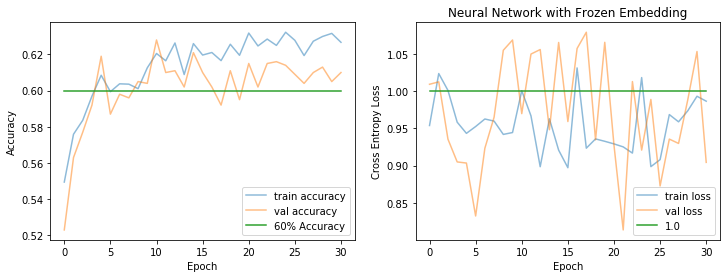

In [16]:
drop = 0.08
learning_rate = 0.01
MAX_SENTENCE_LENGTH = 100
BATCH_SIZE = 32
num_epochs = 10 # number epoch to train

train_acc_list, val_acc_list, train_loss_list, val_loss_list = nn_pipeline(token2id, id2token, MAX_SENTENCE_LENGTH, BATCH_SIZE, learning_rate, drop)
    
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_len = len(train_acc_list)

ax1=plt.subplot(121)
ax1.plot(range(plot_len), train_acc_list, label = 'train accuracy', alpha = 0.5)
ax1.plot(range(plot_len), val_acc_list, label = 'val accuracy', alpha = 0.5)
ax1.plot(range(plot_len), [0.6]*plot_len, label = '60% Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2=plt.subplot(122)
ax2.plot(range(len(train_loss_list)), train_loss_list, label = 'train loss', alpha = 0.5)
ax2.plot(range(len(val_loss_list)), val_loss_list, label = 'val loss', alpha = 0.5)
ax2.plot(range(len(val_loss_list)), [1]*len(val_loss_list), label = '1.0')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Cross Entropy Loss')
ax2.legend()
plt.title('Neural Network with Frozen Embedding')

plt.show()